Notebook for https://github.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine

In [64]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import random
from numpy.linalg import pinv
from numpy.linalg import inv

from sklearn.metrics import r2_score

from sklearn.metrics import mean_absolute_percentage_error

random.seed(0)

In [67]:
def getTimeEmbeddedMatrix(sequence, numLags=100, predictionStep=1):
  #print("generate time embedded matrix")
  inDim = numLags
  X = np.zeros(shape=(len(sequence), inDim))
  T = np.zeros(shape=(len(sequence), 1))
  for i in range(numLags-1, len(sequence)-predictionStep):
    X[i, :] = np.array(sequence[columna][(i-numLags+1):(i+1)])
    T[i, :] = sequence[columna][i+predictionStep]
  print('input shape: ',X.shape)
  print('target shape: ',T.shape)
  return (X, T)

def linear(features,weights,bias):
   return np.dot(features, np.transpose(weights)) + bias

def sigmoidActFunc(features):
  return 1.0 / (1.0 + np.exp(-features))


def reluActFunc(features):
  return np.maximum(0,features)


def computeSquareDeviation(predictions, truth):
  squareDeviation = np.square(predictions-truth)
  return squareDeviation


class OSELM(object):
  def __init__(self, inputs, outputs, numHiddenNeurons, forgettingFactor=0.999):
    self.name = 'OSELM'
    self.inputs = inputs
    self.outputs = outputs
    self.numHiddenNeurons = numHiddenNeurons

    # input to hidden weights
    self.inputWeights = None
    # bias of hidden units
    self.bias = None
    # hidden to output layer connection
    self.beta = None
    # auxiliary matrix used for sequential learning
    self.M = None

    self.forgettingFactor = forgettingFactor

  def calculateHiddenLayerActivation(self, features):
    """
    Calculate activation level of the hidden layer
    :param features feature matrix with dimension (numSamples, numInputs)
    :return: activation level (numSamples, numHiddenNeurons)
    """
    V = linear(features, self.inputWeights,self.bias)
    #H = sigmoidActFunc(V)
    H = reluActFunc(V)
    return H


  def initializePhase(self, lamb=0.0001):
    """
    Step 1: Initialization phase
    """
    # randomly initialize the input->hidden connections
    self.inputWeights = np.random.random((self.numHiddenNeurons, self.inputs))
    self.inputWeights = self.inputWeights * 2 - 1
    self.bias = np.random.random((1, self.numHiddenNeurons)) * 2 - 1
    # auxiliary matrix used for sequential learning
    self.M = inv(lamb*np.eye(self.numHiddenNeurons))
    # hidden to output layer connection
    self.beta = np.zeros([self.numHiddenNeurons,self.outputs])



  def train(self, features, targets):
    """
    Step 2: Sequential learning phase
    :param features feature matrix with dimension (numSamples, numInputs)
    :param targets target matrix with dimension (numSamples, numOutputs)
    """
    (numSamples, numOutputs) = targets.shape
    assert features.shape[0] == targets.shape[0]

    H = self.calculateHiddenLayerActivation(features)
    Ht = np.transpose(H)


    self.M = (1/self.forgettingFactor) * self.M - np.dot((1/self.forgettingFactor) * self.M,
                                     np.dot(Ht, np.dot(
                                       pinv(np.eye(numSamples) + np.dot(H, np.dot((1/self.forgettingFactor) * self.M, Ht))),
                                       np.dot(H, (1/self.forgettingFactor) * self.M))))
    self.beta = self.beta + np.dot(self.M, np.dot(Ht, targets - np.dot(H, self.beta)))

  def predict(self, features):
    """
    Make prediction with feature matrix
    :param features: feature matrix with dimension (numSamples, numInputs)
    :return: predictions with dimension (numSamples, numOutputs)
    """
    H = self.calculateHiddenLayerActivation(features)
    prediction = np.dot(H, self.beta)
    return prediction


def TrainModel(columna='none',net = None):
    meanSeq = np.mean(df[columna])
    stdSeq = np.std(df[columna])
    df[columna] = (df[columna] - meanSeq)/stdSeq
    predictions= []
    target= []
    (X, T) = getTimeEmbeddedMatrix(df, numLags, predictionStep)
    for i in range(numLags, len(df)-predictionStep-1):
        net.train(X[[i], :], T[[i], :])
        Y = net.predict(X[[i+1], :])

        predictions.append(Y[0][0])
        target.append(T[i][0])

    predictions = np.array(predictions)
    target = np.array(target)
    predictions = predictions * stdSeq + meanSeq
    target = target * stdSeq + meanSeq


    # Calculate NRMSE from skip_eval to the end
    skip_eval=100
    squareDeviation = computeSquareDeviation(predictions, target)
    squareDeviation[:skip_eval] = None
    nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
    print("NRMSE {}".format(nrmse))
    predictions = np.array(predictions)
    target = np.array(target)
    predictions = predictions * stdSeq + meanSeq
    target = target * stdSeq + meanSeq
    
    return nrmse,predictions,target

In [68]:


path = "../datasets/"

input shape:  (17519, 100)
target shape:  (17519, 1)
NRMSE 0.34010802639478355
R2 = 0.8790330176701582


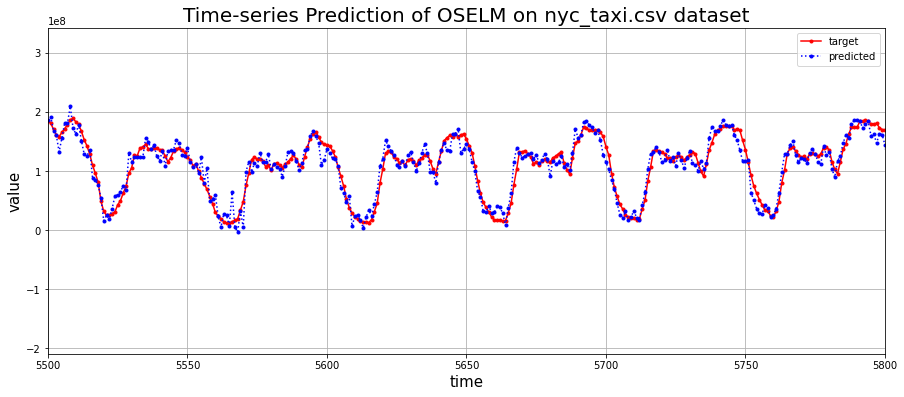

Text(0.5, 0, 'Real Value')

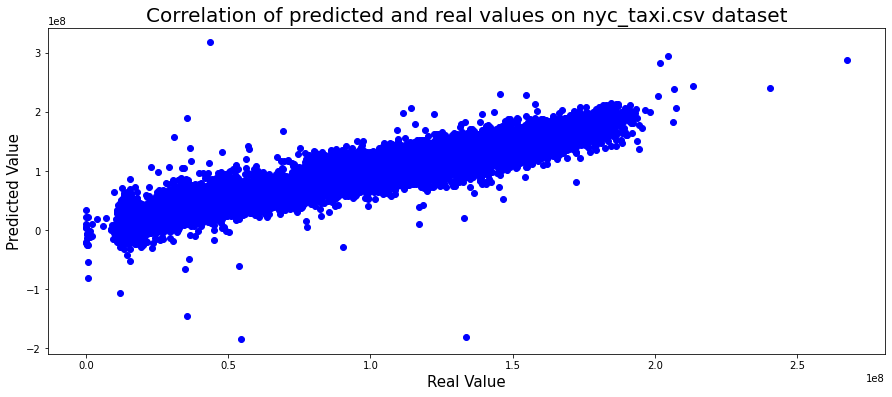

In [69]:
#FOR NYC TAXI DATASET


numLags = 100
predictionStep = 5

nDimInput = numLags
nDimOutput = 1
numNeurons = 25
lamb=0.0001
outputWeightFF = 0.92 

dataset = "nyc_taxi.csv"
columna = 'passenger_count'

df = pd.read_csv(path + dataset, header=0, skiprows=[1])


net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
net.initializePhase(lamb=lamb)

nrmse,predictions,target = TrainModel(columna='passenger_count',net = net)


print("R2 =",r2_score(target, predictions))
#print("MAPE =",mean_absolute_percentage_error(target, predictions))

algorithm= net.name
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([5500,5800])
#plt.ylim([0, 30000])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataset+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)


plt.figure(figsize=(15,6))
plt.plot(target,predictions,'bo')
plt.title('Correlation of predicted and real values' + ' on '+dataset+' dataset',fontsize=20,fontweight=40)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Real Value',fontsize=15)



input shape:  (4176, 100)
target shape:  (4176, 1)
NRMSE 0.9568548657307272
R2 = -1.4064836718649154


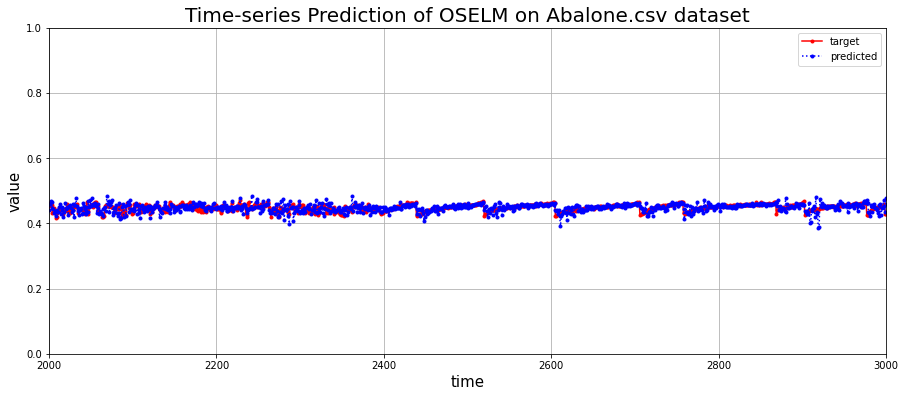

Text(0.5, 0, 'Real Value')

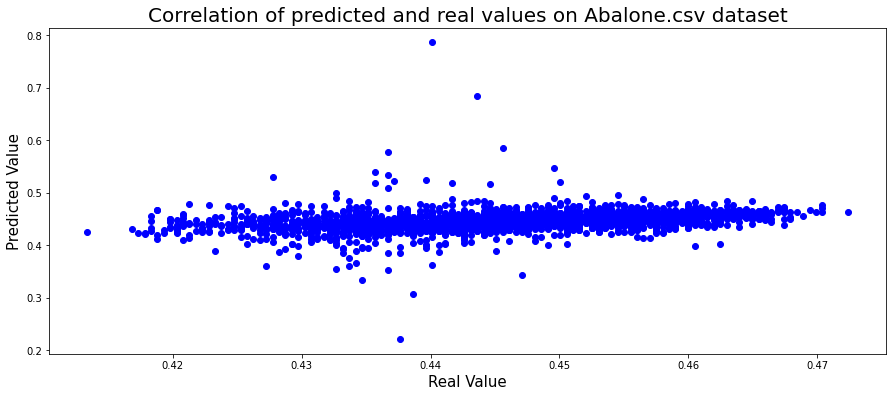

In [70]:
#FOR ABALONE DATASET
dataset = "Abalone.csv"
columna = 'diameter'

df = pd.read_csv(path + dataset, header=0, skiprows=[1])

net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
net.initializePhase(lamb=lamb)

nrmse,predictions,target = TrainModel(columna=columna,net = net)



print("R2 =",r2_score(target, predictions))
#print("MAPE =",mean_absolute_percentage_error(target, predictions))


algorithm= net.name
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([2000,3000])
plt.ylim([0, 1])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataset+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)

plt.figure(figsize=(15,6))
plt.plot(target,predictions,'bo')
plt.title('Correlation of predicted and real values' + ' on '+dataset+' dataset',fontsize=20,fontweight=40)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Real Value',fontsize=15)


input shape:  (397, 100)
target shape:  (397, 1)
NRMSE 0.8913387398265162
R2 = -0.46633912565390445


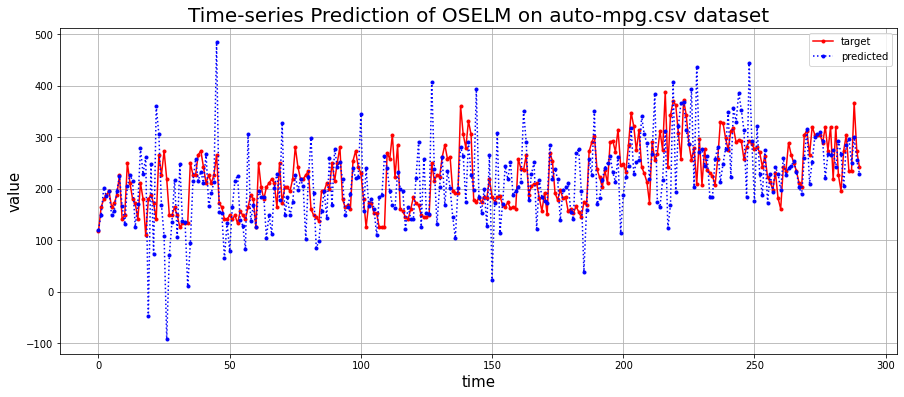

Text(0.5, 0, 'Real Value')

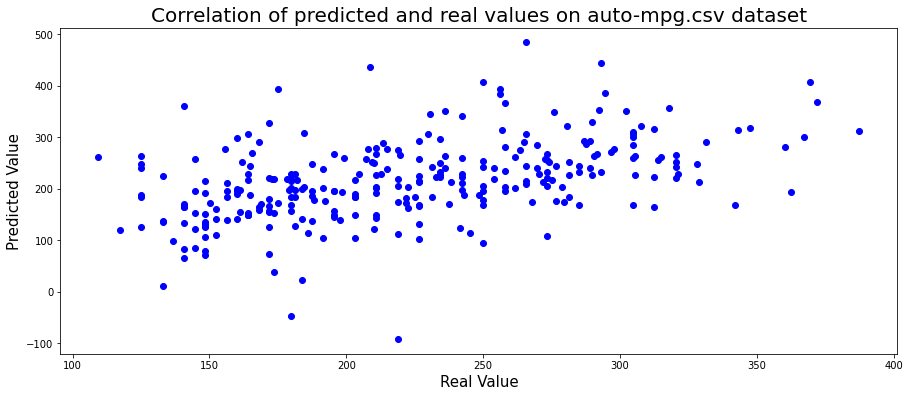

In [142]:
#FOR AUTO MPG DATASET
dataset = "auto-mpg.csv"
columna = 'mpg'


df = pd.read_csv(path + dataset, header=0, skiprows=[1])


net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
net.initializePhase(lamb=lamb)

nrmse,predictions,target = TrainModel(columna=columna,net = net)

print("R2 =",r2_score(target, predictions))
#print("MAPE =",mean_absolute_percentage_error(target, predictions))


algorithm= net.name
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
#plt.xlim([2000,3000])
#plt.ylim([0, 50])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataset+' dataset',fontsize=20,fontweight=40)

plt.draw()
plt.show()
plt.pause(0)

plt.figure(figsize=(15,6))
plt.plot(target,predictions,'bo')
plt.title('Correlation of predicted and real values' + ' on '+dataset+' dataset',fontsize=20,fontweight=40)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Real Value',fontsize=15)

input shape:  (448, 100)
target shape:  (448, 1)
NRMSE 0.015135281432813973
R2 = 0.9996223278282281


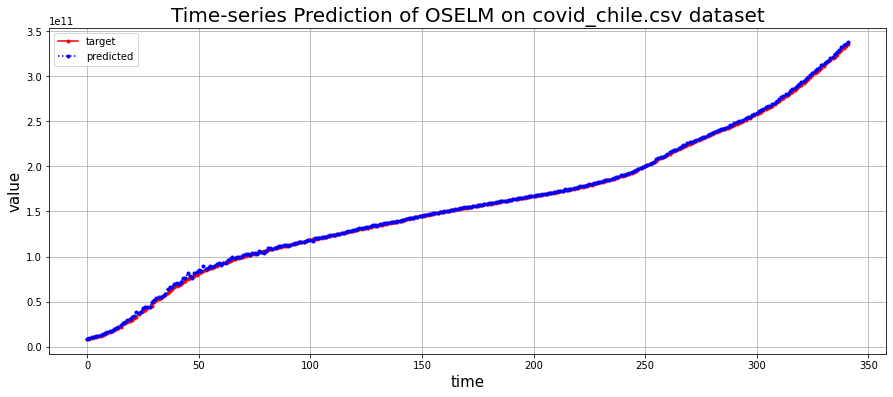

Text(0.5, 0, 'Real Value')

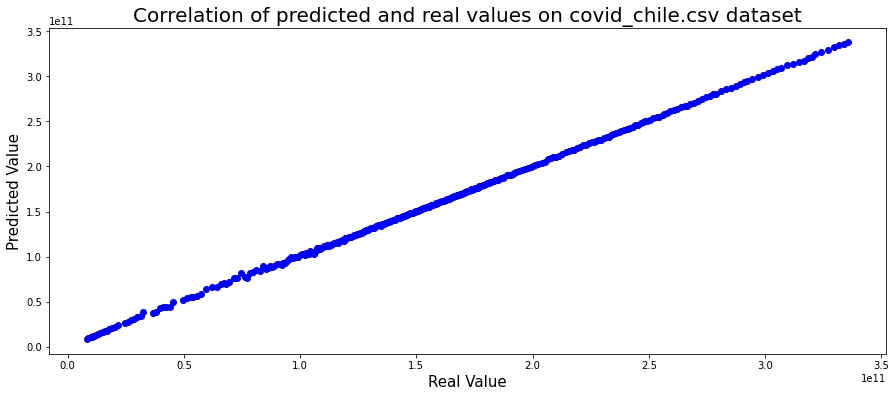

In [144]:
#FOR COVID CHILE DATASET
dataset = "covid_chile.csv"
columna = 'confirmed'

df = pd.read_csv(path + dataset, header=0, skiprows=[1])

net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
net.initializePhase(lamb=lamb)

nrmse,predictions,target = TrainModel(columna=columna,net = net)


print("R2 =",r2_score(target, predictions))
#print("MAPE =",mean_absolute_percentage_error(target, predictions))


algorithm= net.name
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
#plt.xlim([2000,3000])
#plt.ylim([0, 1])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataset+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)

plt.figure(figsize=(15,6))
plt.plot(target,predictions,'bo')
plt.title('Correlation of predicted and real values' + ' on '+dataset+' dataset',fontsize=20,fontweight=40)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Real Value',fontsize=15)

input shape:  (1257, 100)
target shape:  (1257, 1)
NRMSE 0.29506920993256547
R2 = 0.9142179864632112


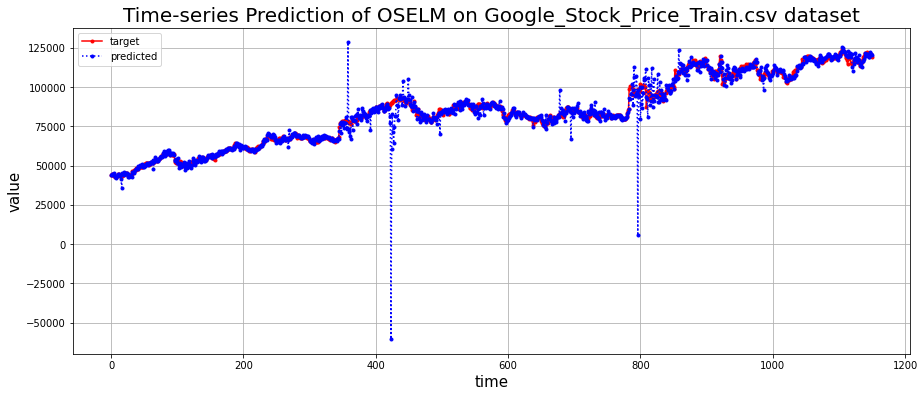

Text(0.5, 0, 'Real Value')

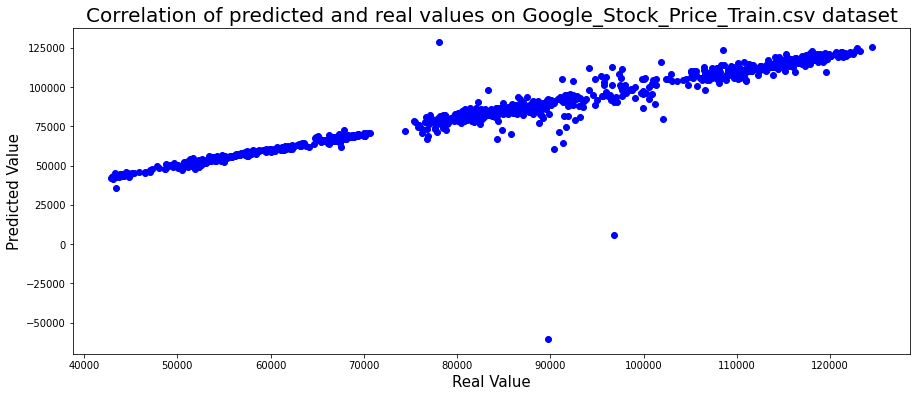

In [152]:
#FOR Google Stock Price DATASET
dataset = "Google_Stock_Price_Train.csv"
columna = 'Open'

df = pd.read_csv(path + dataset, header=0, skiprows=[1])
df["day"] = [t.day for t in pd.DatetimeIndex(df.Date)]
df["month"] = [t.month for t in pd.DatetimeIndex(df.Date)]
df['year'] = [t.year for t in pd.DatetimeIndex(df.Date)]
df.drop(['Date',"day","month"],inplace=True,axis=1)

df['Volume'] = df['Volume'].str.replace(',', '')
#raw['Open'] = raw['Open'].str.replace(',', '')
#raw['High'] = raw['High'].str.replace(',', '')
df['Close'] = df['Close'].str.replace(',', '')

net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
net.initializePhase(lamb=lamb)

nrmse,predictions,target = TrainModel(columna=columna,net = net)

print("R2 =",r2_score(target, predictions))
#print("MAPE =",mean_absolute_percentage_error(target, predictions))


algorithm= net.name
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
#plt.xlim([600,1000])
#plt.ylim([400, 1000])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataset+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.draw()
plt.show()


plt.figure(figsize=(15,6))
plt.plot(target,predictions,'bo')
plt.title('Correlation of predicted and real values' + ' on '+dataset+' dataset',fontsize=20,fontweight=40)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Real Value',fontsize=15)


input shape:  (20432, 100)
target shape:  (20432, 1)
NRMSE 1.0024876585050733
R2 = -4.701307461574434e+137


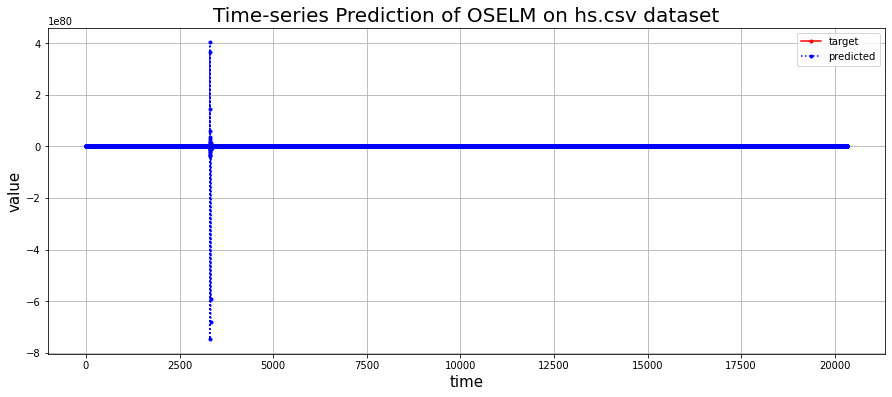

Text(0.5, 0, 'Real Value')

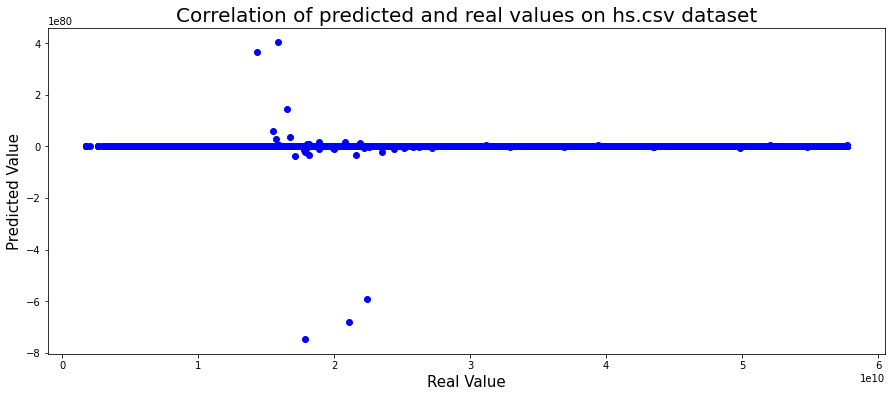

In [158]:
#FOR HS DATASET
dataset = "hs.csv"
columna = 'median_house_value'


df = pd.read_csv(path + dataset, header=0, skiprows=[1])

m = {'NEAR BAY':0,'<1H OCEAN':1,'INLAND':2,'NEAR OCEAN':3,'ISLAND':4}
df = df.replace({'ocean_proximity':m})


net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
net.initializePhase(lamb=lamb)

nrmse,predictions,target = TrainModel(columna=columna,net = net)

print("R2 =",r2_score(target, predictions))
#print("MAPE =",mean_absolute_percentage_error(target, predictions))


algorithm= net.name
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
#plt.xlim([5000,7500])
#plt.ylim([100000, 300000])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataset+' dataset',fontsize=20,fontweight=40)

plt.draw()
plt.show()

plt.figure(figsize=(15,6))
plt.plot(target,predictions,'bo')
plt.title('Correlation of predicted and real values' + ' on '+dataset+' dataset',fontsize=20,fontweight=40)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Real Value',fontsize=15)

input shape:  (4392, 100)
target shape:  (4392, 1)
NRMSE 0.6119262363093392
R2 = 0.5619569615811559


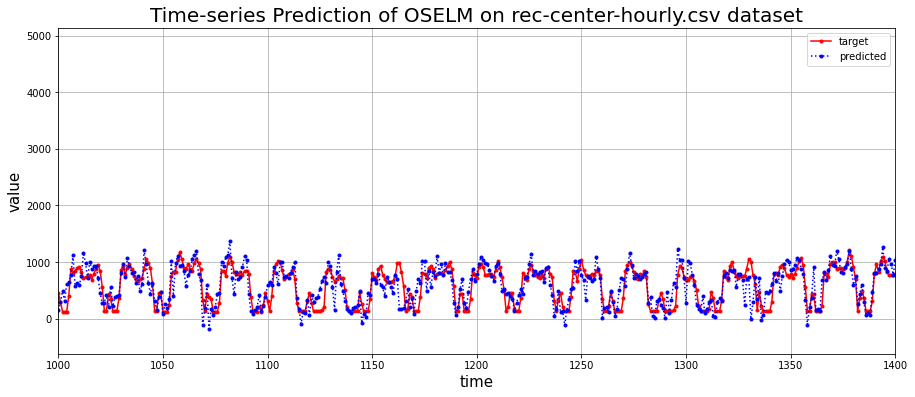

Text(0.5, 0, 'Real Value')

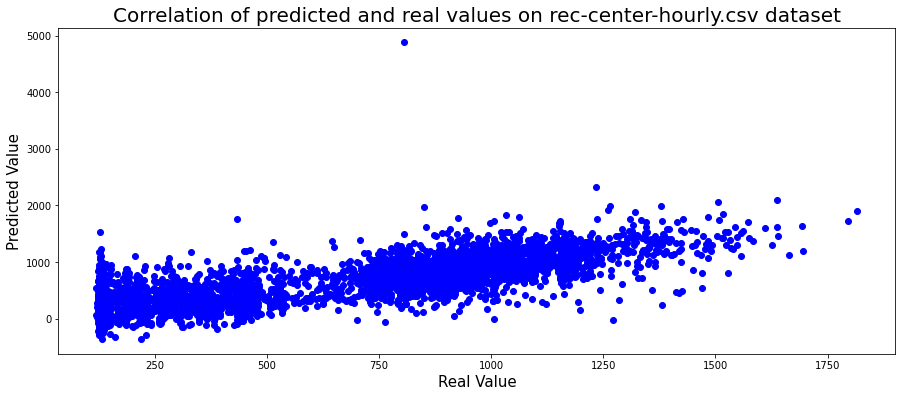

In [162]:
#FOR REC CENTER DATASET
dataset = "rec-center-hourly.csv"
columna = 'kw_energy_consumption'

df = pd.read_csv(path + dataset, header=0, skiprows=[1])

net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
net.initializePhase(lamb=lamb)

nrmse,predictions,target = TrainModel(columna=columna,net = net)

print("R2 =",r2_score(target, predictions))
#print("MAPE =",mean_absolute_percentage_error(target, predictions))


algorithm= net.name
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([1000,1400])
#plt.ylim([0, 50])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataset+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.draw()
plt.show()


plt.figure(figsize=(15,6))
plt.plot(target,predictions,'bo')
plt.title('Correlation of predicted and real values' + ' on '+dataset+' dataset',fontsize=20,fontweight=40)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Real Value',fontsize=15)


input shape:  (1100, 100)
target shape:  (1100, 1)
NRMSE 0.9726745082497631
R2 = -1.346456660495602


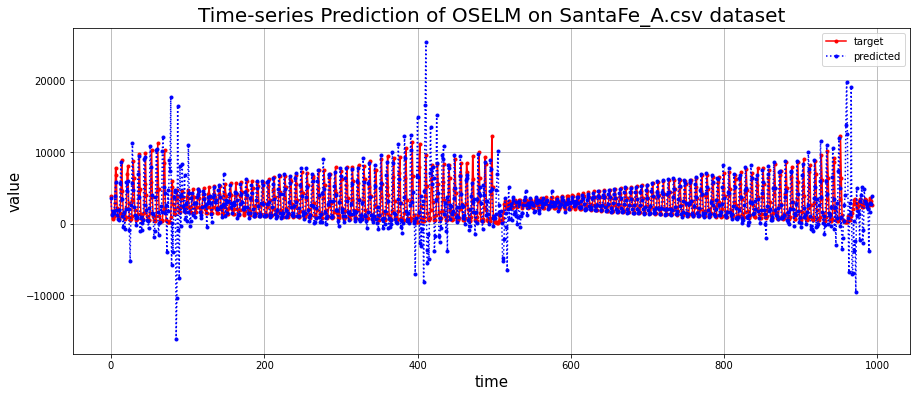

Text(0.5, 0, 'Real Value')

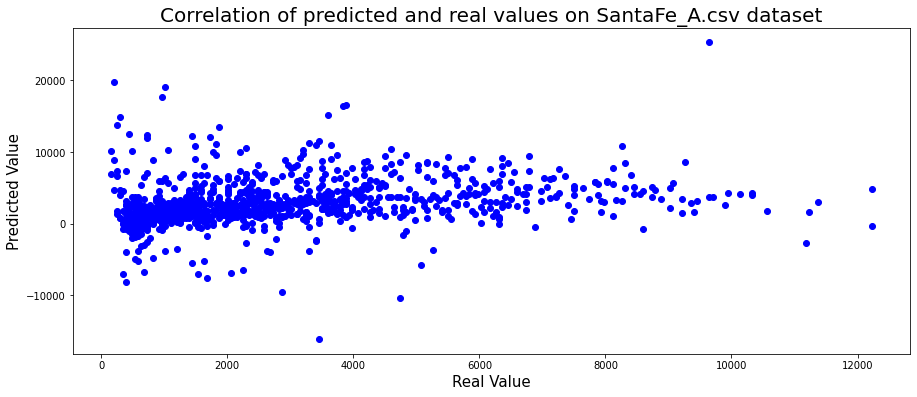

In [163]:
#FOR SANTA FE DATASET
dataset = "SantaFe_A.csv"
columna = 'data'

df = pd.read_csv(path + dataset, header=0, skiprows=[1,2])

net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
net.initializePhase(lamb=lamb)

nrmse,predictions,target = TrainModel(columna=columna,net = net)

print("R2 =",r2_score(target, predictions))
#print("MAPE =",mean_absolute_percentage_error(target, predictions))


algorithm= net.name
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
#plt.xlim([1000,2000])
#plt.ylim([0, 250])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataset+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.draw()
plt.show()

plt.figure(figsize=(15,6))
plt.plot(target,predictions,'bo')
plt.title('Correlation of predicted and real values' + ' on '+dataset+' dataset',fontsize=20,fontweight=40)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Real Value',fontsize=15)

input shape:  (2000, 100)
target shape:  (2000, 1)
NRMSE 0.20128453509698827
R2 = 0.959104213334828


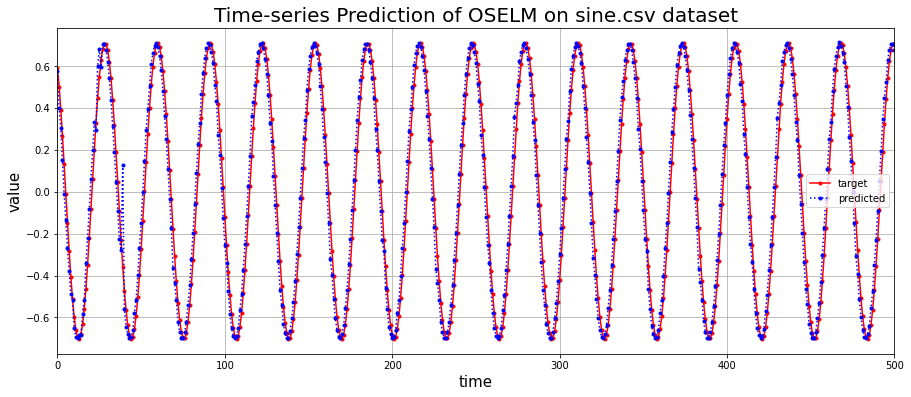

Text(0.5, 0, 'Real Value')

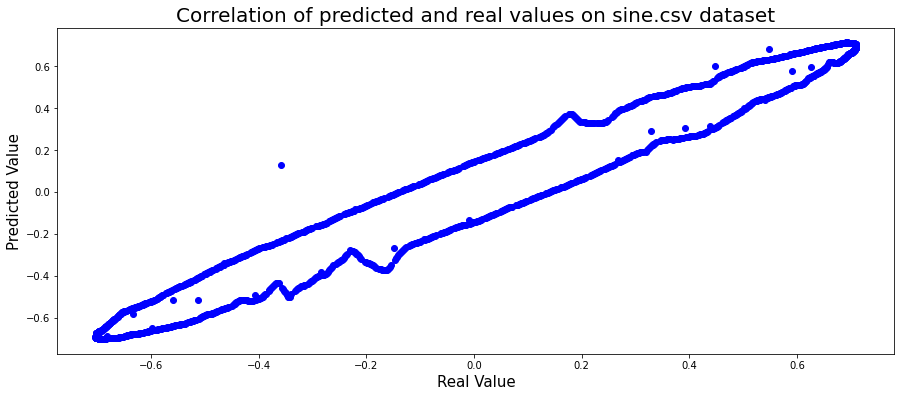

In [165]:
#FOR SINE DATASET
dataset = "sine.csv"
columna = 'data'

df = pd.read_csv(path + dataset, header=0, skiprows=[1,2])

net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
net.initializePhase(lamb=lamb)

nrmse,predictions,target = TrainModel(columna=columna,net = net)

print("R2 =",r2_score(target, predictions))
#print("MAPE =",mean_absolute_percentage_error(target, predictions))

algorithm= net.name
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([0,500])
#plt.ylim([0, 250])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataset+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.draw()
plt.show()

plt.figure(figsize=(15,6))
plt.plot(target,predictions,'bo')
plt.title('Correlation of predicted and real values' + ' on '+dataset+' dataset',fontsize=20,fontweight=40)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Real Value',fontsize=15)

input shape:  (10884, 100)
target shape:  (10884, 1)
NRMSE 0.7458348676747796
R2 = 0.3721906185823102


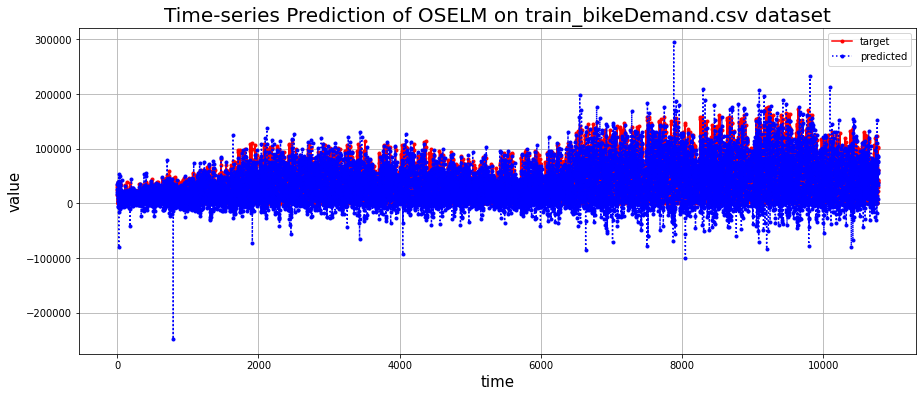

Text(0.5, 0, 'Real Value')

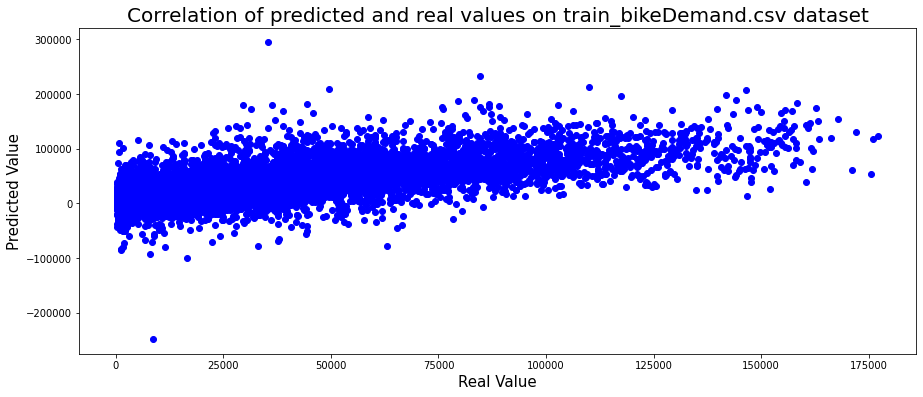

In [172]:
#FOR BIKE DEMAND DATASET
dataset = "train_bikeDemand.csv"
columna = 'count'

df = pd.read_csv(path + dataset, header=0, skiprows=[1,2])
df = df.drop(df.columns[0], axis=1) # for train_bikeDemand.csv dataset

net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
net.initializePhase(lamb=lamb)

nrmse,predictions,target = TrainModel(columna=columna,net = net)

print("R2 =",r2_score(target, predictions))
#print("MAPE =",mean_absolute_percentage_error(target, predictions))

algorithm= net.name
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
#plt.xlim([0,2000])
#plt.ylim([0, 1000])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataset+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.draw()
plt.show()

plt.figure(figsize=(15,6))
plt.plot(target,predictions,'bo')
plt.title('Correlation of predicted and real values' + ' on '+dataset+' dataset',fontsize=20,fontweight=40)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Real Value',fontsize=15)